## Mini Project: Building a database for crime reports

I've been learning about postgres recently and in this project, I just want to put everything together to build a database for storing data related to crimes that occurred in Boston. This dataset is available in the file boston.csv. 

The goal of this project is to create a database named `crimes_db` with a table – `boston_crimes` – with appropriate datatypes for storing the data from the `boston.csv` file. I will be creating the table inside a schema named `crimes`. I will also create the `readonly` and `readwrite` groups with the appropriate privileges. Finally, I will also need to create one user for each of these groups.

The following diagram illustrates a high-level overview of what I want to achieve:

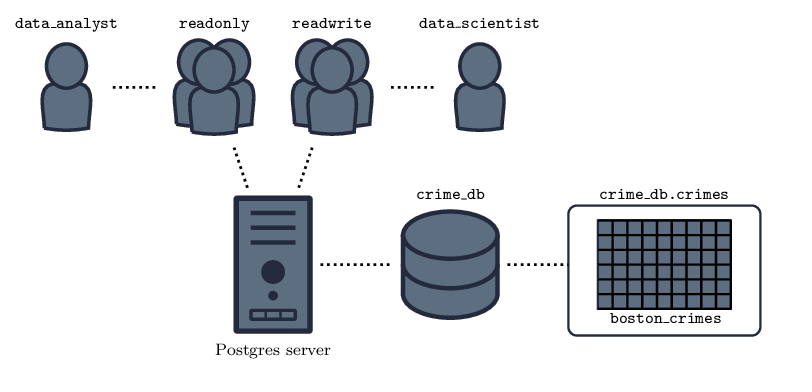


I will start by creating a database for storing our crime data as well as a schema for containing the tables. 
Inside this database, I will create a schema to keep my data organized. 


In [1]:
import psycopg2


In [2]:
conn = psycopg2.connect(dbname = 'postgres', user = 'postgres', password = 'P@ssw0rd')
conn.autocommit = True    #Setting Autocommit to 'True' so that connection can commit after every execute statement. This is because creating a database has to be a standalone transaction
cur = conn.cursor()
cur.execute("CREATE DATABASE crime_db;")
conn.autocommit = False
conn.close()

DuplicateDatabase: database "crime_db" already exists


Notice that I connected to the postgres database to create my desired database. Now, every subsequent task I'm doing will be done by connecting to my new database, hence, I'll have a new connection string.

Time to create the schema

In [3]:
conn2 = psycopg2.connect(dbname = 'crime_db', user = 'postgres', password = 'P@ssw0rd')
cur = conn2.cursor()
cur.execute("CREATE SCHEMA crimes;")
conn2.commit()

DuplicateSchema: schema "crimes" already exists


Now I have created the schema `crimes` in the database `crimes_db`. The following diagram illustrates what the database should look like

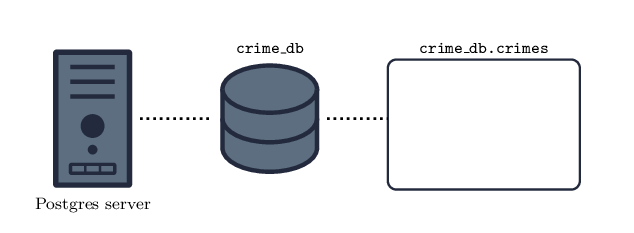

I now have a database and a schema — I'm ready to start creating tables. Before I do that, let me gather some data about the crime dataset so that I can easily select the right datatypes to use in our table.

I'll start by reading the column names from the boston.csv file as well as the first row. This way, I will have them at hand throughout this project so I can easily refer to them.

In [4]:
import csv
with open("C:/Users/kenechukwu.ifediorah/OneDrive - EverCare (1)/Documents/PythonDA/Datasets/Guided Project_ Building a database for crime reports/boston.csv", encoding = "utf-8") as file:
    reader = csv.reader(file)
    crime_data = list(reader)
col_headers = crime_data[0]
first_row = crime_data[1]
print(col_headers)
print(first_row)

['incident_number', 'offense_code', 'description', 'date', 'day_of_the_week', 'lat', 'long']
['1', '619', 'LARCENY ALL OTHERS', '2018-09-02', 'Sunday', '42.35779134', '-71.13937053']


Before I create a table to store the crime data, I need to identify the proper datatypes for the columns. To help me with that, I'll create a function — `get_col_set()` — that, given the name of a CSV file and a column index (starting at 0), computes a Python set with all distinct values contained in that column.


This function will be useful for two reasons:

- Checking whether an enumerated datatype might be a good choice for representing a column
- Computing the maximum length of any text-like column to select appropriate sizes for VARCHAR columns

In [5]:
def get_col_set(csv_filename, col_index):
    with open(csv_filename, encoding = "utf-8") as file:
        reader = list(csv.reader(file))
        data = reader[1:]
    return set([i[col_index] for i in data])

Now, I'll use a for loop and the get_col_set() function to compute, for each of the seven columns in `crime_data` (indexes 0 to 6), the number of different values it contains.

In [6]:
csv_file = "C:/Users/kenechukwu.ifediorah/OneDrive - EverCare (1)/Documents/PythonDA/Datasets/Guided Project_ Building a database for crime reports/boston.csv"
for i in col_headers:
    length = len(get_col_set(csv_file, col_headers.index(i)))
    print(i," = ",length)

incident_number  =  298329
offense_code  =  219
description  =  239
date  =  1177
day_of_the_week  =  7
lat  =  18177
long  =  18177


Another important aspect is to know the longest word in any column containing textual data. We can actually use the same function for computing this:

- Use the get_col_set() function to get the distinct values of that column into a variable named col_values.
- Iterate over the elements of col_values, and find the longest one.

There are two textual columns in the dataset, namely, the description and day_of_the_week columns. However, the day of the week contains only seven values — one for each day. I can tell that the longest of them is Wednesday without any computation.

Let me compute the maximum length of each value in the description column. The description column has index = 2

In [7]:
len_values = [len(i) for i in get_col_set(csv_file, 2)]
max_length = max(len_values)
print(max_length)

58


Now I know the data types and max length of textual data in the dataset, I can go ahead to create the `boston_crimes` table.

For the day_of_the_week column, I would create an enumerate datatype as this would fit perfectly since it has only 7 distinct items

In [8]:
print(col_headers)

['incident_number', 'offense_code', 'description', 'date', 'day_of_the_week', 'lat', 'long']


In [11]:
conn3 = psycopg2.connect(dbname = 'crime_db', user = 'postgres', password = 'P@ssw0rd')
cur = conn3.cursor()

cur.execute("CREATE TYPE enum_weekday AS ENUM ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')")

DuplicateObject: type "enum_weekday" already exists


In [13]:
conn3.commit()
conn3.close()

So now, I've created the ENUM data type for weekdays and I have the names of the data headers.

I've decided to use the following data types for my table

|Column Name | Data Type | Properties|
|------------|-----------|-----------|
|incident_id | INTEGER | PRIMARY KEY|
|offense_id | INTEGER | NULL|
|description | varchar(100) | NULL |
|date | DATE | NULL |
|weekday | enum_weekday | NULL |
|latitude | float | NULL |
|longitude | float | NULL |

Now, I will create the table for my data and load data into it. The table will look like this
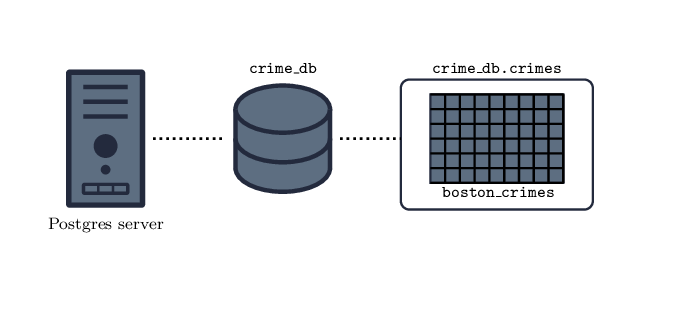

In [23]:
conn4 = psycopg2.connect(dbname = 'crime_db', user = 'postgres', password = 'P@ssw0rd')
cur = conn4.cursor()

cur.execute("""CREATE TABLE crimes.boston_crimes(
            incident_id INTEGER PRIMARY KEY,
            offense_id INTEGER,
            description VARCHAR(100),
            date DATE,
            weekday ENUM_WEEKDAY,
            latitude FLOAT,
            longitude FLOAT
            )"""
            )
conn4.commit()
conn4.close()

DuplicateTable: relation "boston_crimes" already exists


My database is starting to look good! I have created a database with a schema inside it to hold data about crimes. I selected the right datatypes for storing the data, created a table, and loaded the CSV containing crimes about Boston.

Now it's time to handle users. The goal is to create the two user groups: readonly and readwrite. By following the least privilege principle, the first step in doing so is to make sure that there are no privileges inherited from the public group and on the public schema. 
I'll do that now

In [32]:
conn5 = psycopg2.connect(dbname = 'crime_db', user = 'postgres', password = 'P@ssw0rd')
cur = conn5.cursor()

cur.execute("REVOKE ALL ON SCHEMA public FROM public;")
cur.execute("REVOKE ALL ON DATABASE crime_db FROM public;")

conn5.commit()

I've made sure that I'm not going to inadvertently inherit privileges from the public group. The next step is to create the two user groups.

The readonly group is supposed to only have privileges to perform SELECT queries. In contrast, I want the readwrite group to be able to perform SELECT, INSERT, DELETE, and UPDATE queries.

They will both also need 
- Connection privileges on the crime_db — otherwise, they won't be able to do anything. 
- Usage of the crimes schema — this is where all data will be stored.

In [33]:
cur.execute("CREATE GROUP readonly NOLOGIN")
cur.execute("CREATE GROUP readwrite NOLOGIN")


In [34]:
conn5.commit()

In [35]:
cur.execute("GRANT SELECT ON ALL TABLES IN SCHEMA crimes TO readonly")
cur.execute("GRANT SELECT, INSERT, DELETE, UPDATE ON ALL TABLES IN SCHEMA crimes TO readonly")
conn5.commit()

In [36]:
cur.execute("GRANT CONNECT ON DATABASE crime_db TO readonly, readwrite")
cur.execute("GRANT USAGE ON SCHEMA crimes TO readonly, readwrite")
conn5.commit()

In [37]:
conn5.close()

I am nearly done with setting up the crime database. The only thing that I need to do is create users. Right now, the high-level picture of the database looks like this:

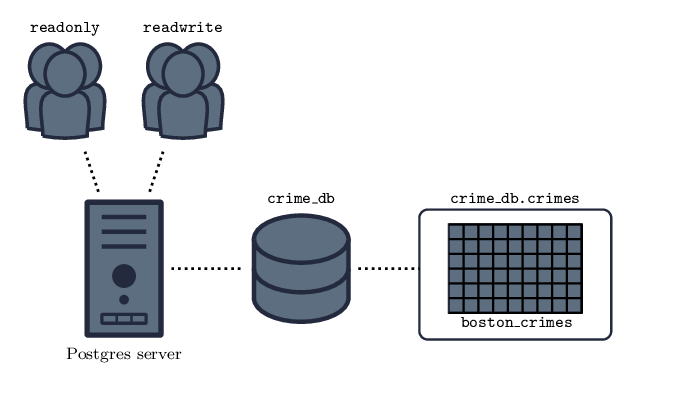

I'll finish the project by creating one user in each group. I will need to create each user and then assign them to each group.

In [38]:
conn6 = psycopg2.connect(dbname = 'crime_db', user = 'postgres', password = 'P@ssw0rd')
cur = conn6.cursor()crime_db

In [39]:
cur.execute("CREATE USER data_analyst WITH PASSWORD 'Secret1'")
cur.execute("CREATE USER data_scientist WITH PASSWORD 'Secret2'")
conn6.commit()

In [40]:
cur.execute("GRANT readonly TO data_analyst")
cur.execute("GRANT readwrite TO data_scientist")
conn6.commit()

In [41]:
conn6.close()

Now, I have finished setting up and my database should look something like this:

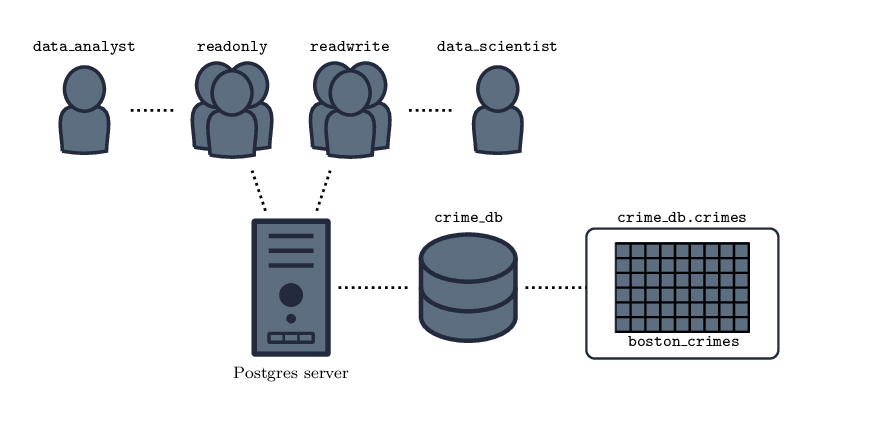

It's a good practice to test that everything is configured as expected when you finish setting up the database. I can query Postgres internal tables to see this information.

I can use SQL queries to check whether the objects have been created and that users and groups have the right privileges. This requires you to know the Postgres internal tables. I can query the pg_roles table to inspect privileges related to the database and the information_schema.table_privileges table to inspect table privileges.


In [45]:
conn7 = psycopg2.connect(dbname = 'crime_db', user = 'postgres', password = 'P@ssw0rd')
cur = conn7.cursor()
cur.execute("""SELECT grantee, privilege_type
    FROM information_schema.table_privileges
    WHERE grantee = 'readwrite';""")
for i in cur.fetchall():
    print(i)
conn7.commit()